In [1]:

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2, DenseNet121, MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# Direktori dataset
TRAIN_DIR = 'C:/Users/agung/OneDrive/Documents/Tomato/Dataset/train/'
VALIDATION_DIR = 'C:/Users/agung/OneDrive/Documents/Tomato/Dataset/val/'

# Preprocessing dan Augmentasi
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(150, 150), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, target_size=(150, 150), batch_size=32, class_mode='categorical')

# Definisi parameter
num_labels = len(train_generator.class_indices)
img_shape = (150, 150, 3)

Found 10000 images belonging to 10 classes.
Found 984 images belonging to 10 classes.


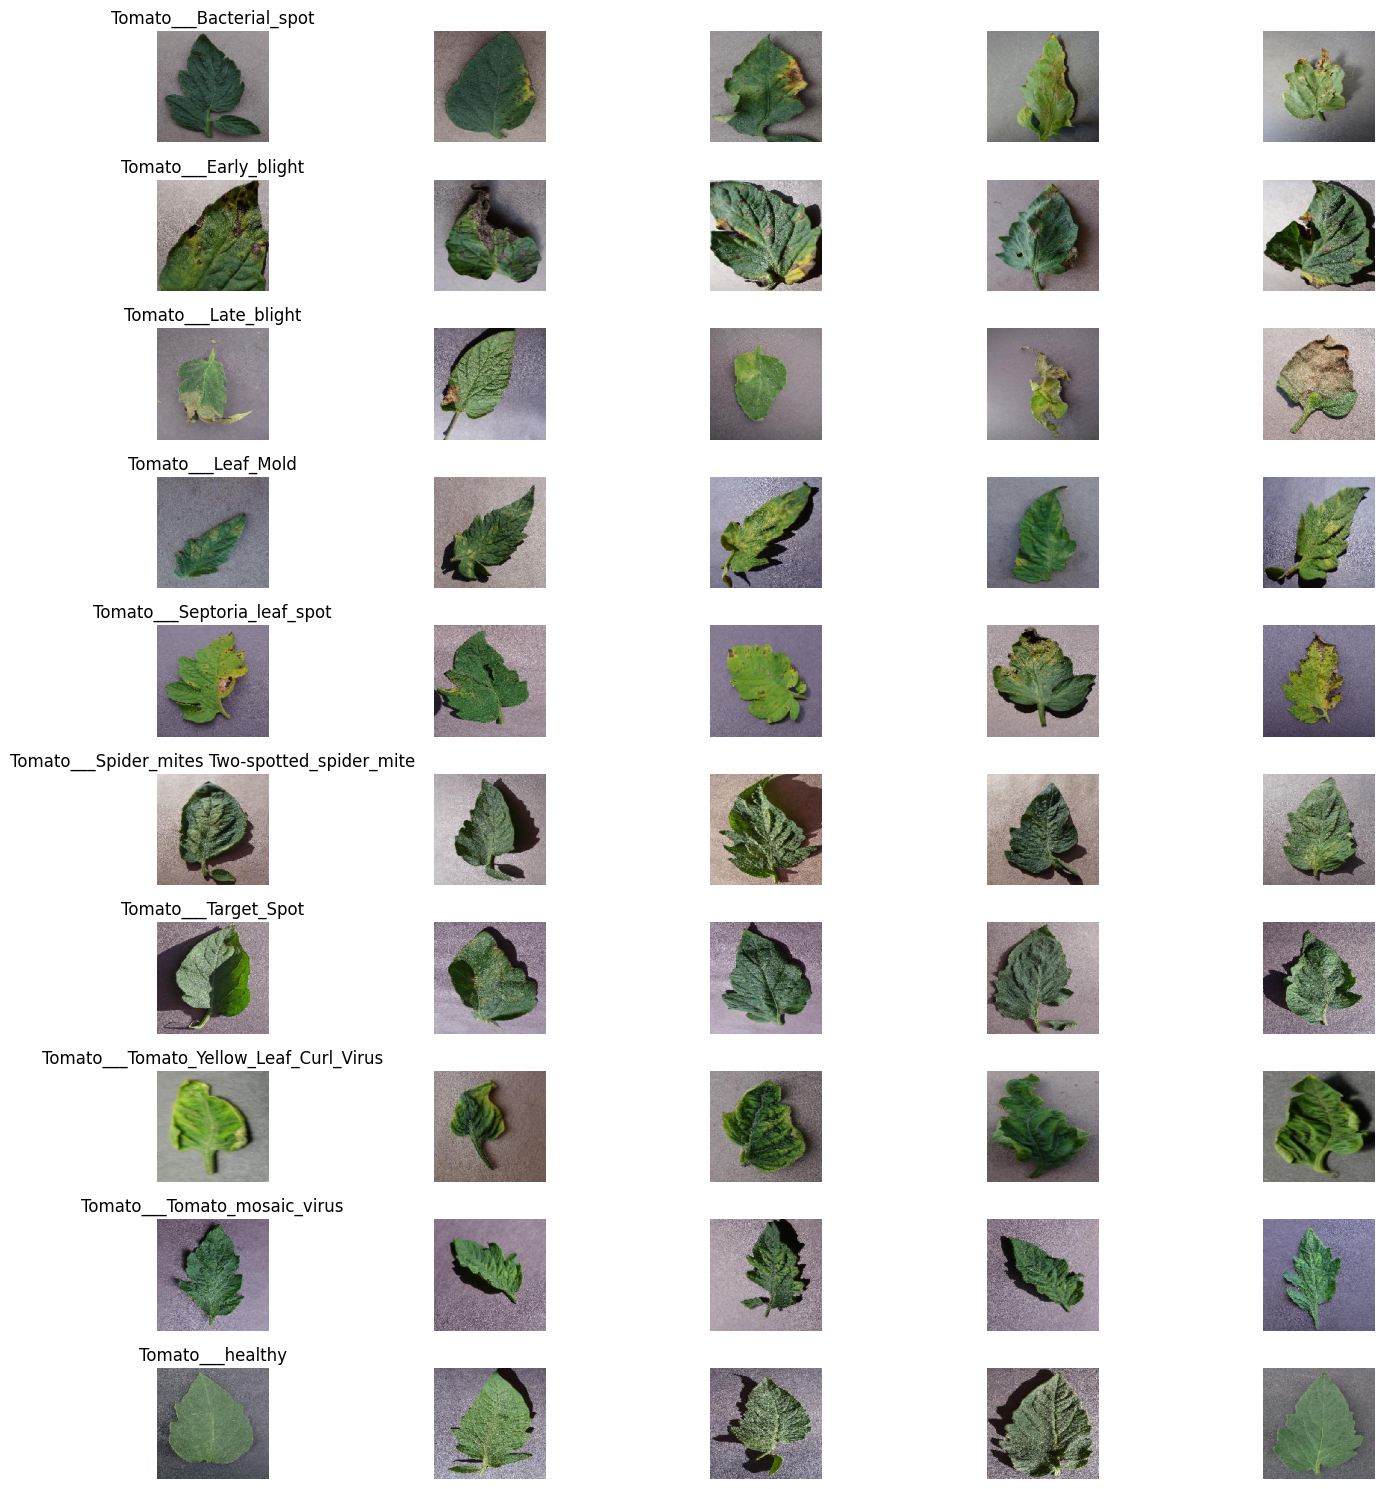

In [3]:
# Fungsi untuk menampilkan beberapa sampel gambar dari setiap kelas
def display_samples_from_all_classes(directory, class_names, num_samples=5):
    plt.figure(figsize=(15, 15))

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        image_files = os.listdir(class_path)[:num_samples]

        for j, img_file in enumerate(image_files):
            img_path = os.path.join(class_path, img_file)
            img = load_img(img_path, target_size=(150, 150))
            img_array = img_to_array(img) / 255.0

            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img_array)
            if j == 0:
                plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Menampilkan 5 sampel gambar dari setiap kelas
class_names = list(train_generator.class_indices.keys())
display_samples_from_all_classes(TRAIN_DIR, class_names)

In [4]:
# Fungsi untuk membuat model
def create_custom_model(base_model, model_name):
    model = Sequential([
        base_model(weights="imagenet", include_top=False, input_shape=img_shape),
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dense(num_labels, activation='softmax')
    ])
    # Freeze backbone model
    model.layers[0].trainable = False
    model.summary()
    print(f"{model_name} model architecture created.\n")
    return model

In [5]:
# Callback untuk menghentikan pelatihan jika val_accuracy > 90%
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.90:
            self.model.stop_training = True
            print("\nReached >90% validation accuracy, stopping training!")

early_stopping_callback = EarlyStoppingCallback()

In [6]:
# Daftar model yang akan dilatih
model_dict = {
    "ResNet152V2": ResNet152V2,
    "DenseNet121": DenseNet121,
    "MobileNetV2": MobileNetV2
}

In [7]:
# Variabel untuk menyimpan hasil terbaik
best_model_name = None
best_val_accuracy = 0
best_history = None

# Dictionary untuk menyimpan riwayat setiap model
history_dict = {}

In [8]:
# Melatih dan mengevaluasi setiap model secara terpisah
for model_name, base_model in model_dict.items():
    print(f"\nTraining {model_name}...")

    # Membuat model kustom
    model = create_custom_model(base_model, model_name)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Melatih model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[early_stopping_callback]
    )

    # Simpan model ke Google Drive
    model_save_path = f'C:/Users/agung/OneDrive/Documents/Tomato/{model_name}_custom.keras'
    model.save(model_save_path)
    print(f"Model {model_name} disimpan sebagai '{model_save_path}'\n")

    # Simpan riwayat training
    history_dict[model_name] = history.history

    # Evaluasi apakah model ini lebih baik
    max_val_accuracy = max(history.history['val_accuracy'])
    if max_val_accuracy > best_val_accuracy:
        best_val_accuracy = max_val_accuracy
        best_model_name = model_name
        best_history = history.history

print(f"\nModel terbaik adalah: {best_model_name} dengan val_accuracy: {best_val_accuracy:.4f}")


Training ResNet152V2...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 5, 5, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,514,634 (227.03 MB)

 Trainable params: 1,182,986 (4.51 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

ResNet152V2 model architecture created.



C:\Users\agung\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4684 - loss: 1.6116

C:\Users\agung\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.4687 - loss: 1.6106 - val_accuracy: 0.7358 - val_loss: 0.7395
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.6713 - loss: 0.9571 - val_accuracy: 0.7754 - val_loss: 0.6274
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.7041 - loss: 0.8472 - val_accuracy: 0.7866 - val_loss: 0.5799
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.7359 - loss: 0.7801 - val_accuracy: 0.8059 - val_loss: 0.5239
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.7513 - loss: 0.7189 - val_accuracy: 0.8222 - val_loss: 0.5442
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.7747 - loss: 0.6544 - val_accuracy: 0.8323 - val_loss: 0.4862
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 473s 2s/step - accuracy: 0.7839 - loss: 0.6339 - val_accuracy: 0.8323 - val_loss: 0.4698
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 480s 2s/step - accuracy: 0.7810 - loss: 0.6359 - val_accuracy: 0.844

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,696,202 (29.36 MB)

 Trainable params: 658,698 (2.51 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

DenseNet121 model architecture created.

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 188s 559ms/step - accuracy: 0.4366 - loss: 1.6561 - val_accuracy: 0.7124 - val_loss: 0.8171
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 170s 543ms/step - accuracy: 0.7003 - loss: 0.8485 - val_accuracy: 0.7530 - val_loss: 0.6745
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 167s 535ms/step - accuracy: 0.7395 - loss: 0.7600 - val_accuracy: 0.7835 - val_loss: 0.5884
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 166s 529ms/step - accuracy: 0.7563 - loss: 0.7003 - val_accuracy: 0.7967 - val_loss: 0.5652
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 167s 532ms/step - accuracy: 0.7772 - loss: 0.6252 - val_accuracy: 0.7876 - val_loss: 0.5784
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 167s 532ms/step - accuracy: 0.7942 - loss: 0.6072 - val_accuracy: 0.8100 - val_loss: 0.4916
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 166s 529ms/step - accuracy: 0.7931 - loss: 0.5915 - val_accuracy: 0.7856 - val_loss: 0.5999
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━

C:\Users\agung\AppData\Local\Temp\ipykernel_6372\2504309358.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model(weights="imagenet", include_top=False, input_shape=img_shape),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 11s 1us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,047,754 (11.63 MB)

 Trainable params: 789,770 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

MobileNetV2 model architecture created.

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 104s 313ms/step - accuracy: 0.4609 - loss: 1.5629 - val_accuracy: 0.7368 - val_loss: 0.7738
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 100s 320ms/step - accuracy: 0.6814 - loss: 0.9037 - val_accuracy: 0.7419 - val_loss: 0.6979
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 313ms/step - accuracy: 0.7165 - loss: 0.8160 - val_accuracy: 0.7530 - val_loss: 0.6498
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 307ms/step - accuracy: 0.7426 - loss: 0.7319 - val_accuracy: 0.7297 - val_loss: 0.7008
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 100s 321ms/step - accuracy: 0.7616 - loss: 0.7050 - val_accuracy: 0.7774 - val_loss: 0.6048
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 102s 325ms/step - accuracy: 0.7635 - loss: 0.6714 - val_accuracy: 0.7856 - val_loss: 0.5923
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 310ms/step - accuracy: 0.7761 - loss: 0.6672 - val_accuracy: 0.7571 - val_loss: 0.6441
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━

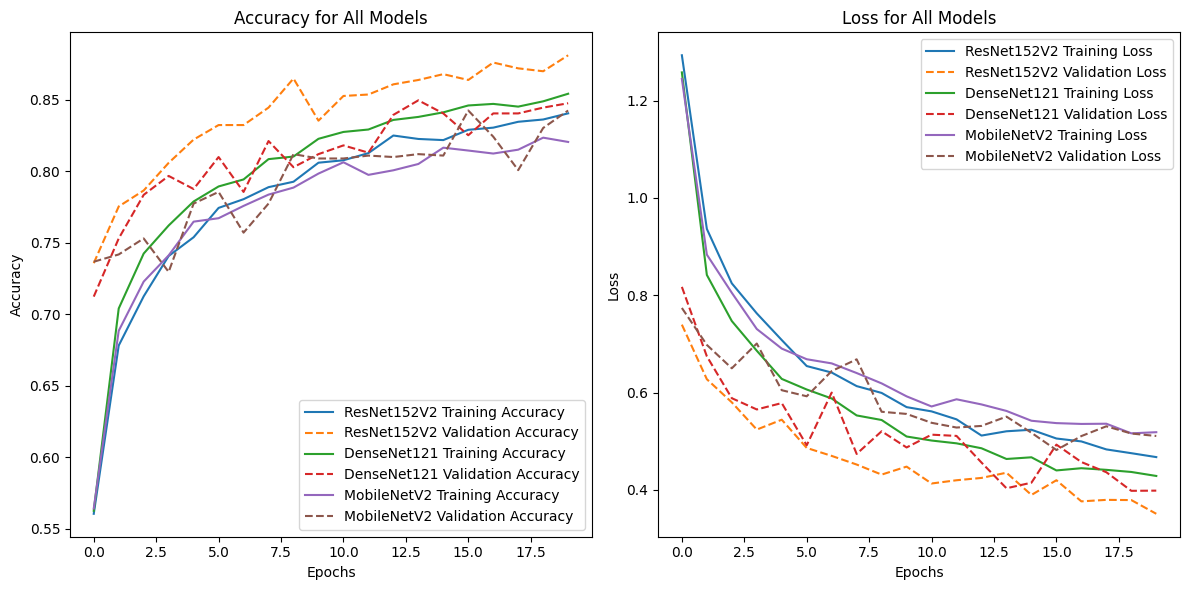

In [9]:
# Menampilkan grafik akurasi dan loss untuk semua model
plt.figure(figsize=(12, 6))

# Plot akurasi
plt.subplot(1, 2, 1)
for model_name, hist in history_dict.items():
    plt.plot(hist['accuracy'], label=f'{model_name} Training Accuracy')
    plt.plot(hist['val_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy')
plt.title('Accuracy for All Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
for model_name, hist in history_dict.items():
    plt.plot(hist['loss'], label=f'{model_name} Training Loss')
    plt.plot(hist['val_loss'], linestyle='--', label=f'{model_name} Validation Loss')
plt.title('Loss for All Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()